Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: Policy Search

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task3.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task3.2: An agent using evolved rules
* Task3.3: An agent using minmax
* Task3.4: An agent using reinforcement learning

## Instructions

* Create the directory `lab3` inside the course repo 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.

**Deadline**

T.b.d.


In [1]:
import logging
import random
import copy
from math import sqrt, exp, isclose
from typing import Callable, Union, List, Tuple
from itertools import accumulate
import operator
import matplotlib.pyplot as plt
from statistics import stdev, mean
import numpy as np

In [2]:
N_HEAPS = 3
N_GAMES = 100

In [3]:
logging.basicConfig(level=logging.INFO)
#random.seed(13)

In [4]:
class Player:
    def __init__(self, name: str, strategy: Callable, *strategy_args):
        self._strategy = strategy
        self._strategy_args = strategy_args
        self._name = name
        self._loser = False
        self._n_plies = 0
    
    def ply(self, state):
        self._strategy(self, state, *self._strategy_args)
        self._n_plies += 1
    
    @property
    def loser(self):
        return self._loser
    
    @loser.setter
    def loser(self, val):
        self._loser = val
    
    @property
    def name(self):
        return self._name
    
    @property
    def n_plies(self):
        return self._n_plies
    
    @n_plies.setter
    def n_plies(self, val):
        self._n_plies = val
    
    def flush_parameters(self):
        self._n_plies = 0
        self._loser = False

class Nim:
    def __init__(self, num_rows: Union[int, None] = None, rows: Union[list, None] = None, k: Union[int, None] = None) -> None:
        if num_rows is not None:
            self._rows = [i*2 + 1 for i in range(num_rows)]
        elif rows:
            self._rows = rows
        else:
            logging.error(f'Wrong arguments for class Nim')
            exit()
        self._k = k

    def nimming(self, row: int, num_objects: int, player: Union[Player, None] = None) -> None:
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects
        if player:
            logging.debug(f"Heaps at player {player.name} turn: {self._rows}")
            logging.debug(f"Player {player.name} takes {num_objects} from heap {row}")
            if sum(self._rows) == 0:
                player.loser = True
    
    def nimsum_state(self) -> bool:
        sum = 0
        for r in self.rows:
            sum ^= r
        return sum == 0
    
    def possible_actions(self) -> List[Tuple[int, int]]:
        actions = []
        for row in range(len(self.rows)):
            for n_obj in range(1, row + 1):
                actions.append((row, n_obj))
        return actions
    
    @property
    def rows(self):
        return self._rows
    
    def copy(self):
        return copy.deepcopy(self)
    
    def get_state_and_reward(self) -> tuple[List[int], int]:
        return self.rows, self.give_reward()

    def give_reward(self) -> int:
        # if nim state give 0
        if self.nimsum_state():
            return 0
        # if normal state give -1
        return -1
    


def play(A: Player, B: Player, state: Nim) -> Player:
    while not (A.loser or B.loser):
        A.ply(state)
        if not A.loser:
            B.ply(state)
    if A.loser:
        return B
    return A

def match(A: Player, B: Player, state: Nim, n_games: int=1):
    winners = list()
    for i in range(n_games):
        initial_state = state.copy()
        A.flush_parameters()
        B.flush_parameters()
        r = random.random()
        if r <= 0.5:
            w = play(A, B, initial_state)
        else:
            w = play(B, A, initial_state)
        winners.append((w.name, w.n_plies))
    return winners

def print_match_result(A: Player, B: Player, res: list):
    n_A_win = 0
    n_games = len(res)
    for i in range(n_games):
        if res[i][0] == A.name:
            n_A_win += 1
    print(f"{A.name} won {n_A_win} times\n{B.name} won {n_games - n_A_win} times") 
    
def random_strategy(player: Player, heaps: Nim, decrement: bool = False):
    non_zero_heaps_idxs = [i for i, v in enumerate(heaps.rows) if v > 0] # choose a random non-zero heap
    idx_heap = random.choice(non_zero_heaps_idxs)
    if decrement:
        quantity = 1
    else:
        quantity = random.randint(1, heaps.rows[idx_heap]) # decrease it of a random quantity
    heaps.nimming(idx_heap, quantity, player)



## Task3.1 Nim-Sum

In [8]:
def nim_sum(rows: List[int]) -> int:
    sum = 0
    for r in rows:
        sum ^= r
    return sum

def check_critical_situations(heaps: list) -> int:
    n_heaps = len(heaps)
    n_heaps_to_zero = len([i for i, h in enumerate(heaps) if h == 0])
    n_heaps_to_one = len([i for i, h in enumerate(heaps) if h == 1])
    n_heaps_greater_than_zero = n_heaps - n_heaps_to_zero
    n_heaps_greater_than_one = n_heaps_greater_than_zero - n_heaps_to_one

    # [1, a, 1, 1, 0, 0], a > 1
    if n_heaps_greater_than_zero % 2 == 0 and n_heaps_greater_than_one == 1:
        return 1
    # [1, a, 1, 0, 0], a > 1
    if n_heaps_greater_than_zero % 2 == 1 and n_heaps_greater_than_one == 1:
        return 2
    # [a, 0, 0], a > 1
    if n_heaps_greater_than_one == 1 and n_heaps_to_one == 0:
        return 3
    # [1, 1, 1, 1, 0, ..., 0] no need to manage this explicitly
    if n_heaps_to_one % 2 == 0 and n_heaps_to_zero + n_heaps_to_one == n_heaps:
        return 4
    # [0, 0, ..., 0] the player has won
    if n_heaps_to_zero == n_heaps:
        return 5
    # [1, 1, 1, 0, ..., 0] 
    if n_heaps_to_one % 2 == 1 and n_heaps_to_zero + n_heaps_to_one == n_heaps:
        return -1
    return 0

def critical_situations(player: Player, heaps: Nim) -> bool:

    code = check_critical_situations(heaps.rows)

    if code != 0:
        if code == 1:  # [1, a, 1, 1, 0, 0], a > 1
            # take all objects from the heap with more than 1 object
            heaps.nimming(heaps.rows.index(max(heaps.rows)),
                          max(heaps.rows), player)
        elif code == 2:  # [1, a, 1, 0, 0], a > 1
            # take all objects but 1 from the heap with more than 1 object
            heaps.nimming(heaps.rows.index(max(heaps.rows)),
                          max(heaps.rows)-1, player)
        elif code == 3:  # [a, 0, 0], a > 1
            # take all objects but 1 from the last non zero heap with more than 1 object
            heaps.nimming(heaps.rows.index(max(heaps.rows)),
                          max(heaps.rows)-1, player)
        elif code == 4 or code == -1: # [1, 1, 0, ..., 0] or [1, 1, 1, 0, ..., 0]
            # take from the first non zero heap
            heaps.nimming(heaps.rows.index(1), 1, player)
        elif code == 5:
            pass
        return True
    else:
        return False

def nim_sum_strategy(player: Player, heaps: Nim):
    if sum(heaps.rows) == 0:
        raise Exception("There is no heap left!")

    logging.debug(
        f"Player: {player.name}, heaps nim-sum: {nim_sum(heaps.rows)}")

    if not critical_situations(player, heaps):
        # normal game
        x = nim_sum(heaps.rows)
        y = [nim_sum([x, h]) for _, h in enumerate(heaps.rows)]
        winning_heaps = [i for i, h in enumerate(heaps.rows) if y[i] < h]
        if len(winning_heaps) > 0:  # if there's a winning heap
            chosen_heap_idx = random.choice(winning_heaps)
            quantity = heaps.rows[chosen_heap_idx]-y[chosen_heap_idx]
            heaps.nimming(chosen_heap_idx, quantity, player)
        else:  # take from a random heap
            random_strategy(player, heaps)

    logging.debug(f"Heaps nim-sum after player {player.name} move: {nim_sum(heaps.rows)}")


In [9]:
# trying nim-sum vs random strategy
heaps = Nim(N_HEAPS)
Alice = Player("Alice (NimSum)", nim_sum_strategy)
Bob = Player("Bob (Random)", random_strategy)
winners = match(Alice, Bob, heaps, N_GAMES)
print_match_result(Alice, Bob, winners)

Alice (NimSum) won 100 times
Bob (Random) won 0 times


In [10]:
# trying nim-sum vs nim-sum strategy
heaps = Nim(N_HEAPS)
Alice = Player("Alice (NimSum)", nim_sum_strategy)
Bob = Player("Bob (NimSum)", nim_sum_strategy)
winners = match(Alice, Bob, heaps, N_GAMES)
print_match_result(Alice, Bob, winners)

Alice (NimSum) won 65 times
Bob (NimSum) won 35 times


## Task3.2 Evolved Rules

In [29]:
# parameters
GENERATIONS = 1_000
POP_SIZE = 500
OFFSPR_NUM = 5*POP_SIZE
FITNESS_N_GAMES = N_GAMES # number of games upon which to evaluate the fitness
GEN_SIZE_PENALTY = 0 # act as a penalty to the fitness, to prefer smaller genomes (NOT ACTUALLY NEEDED)
SURVIVOR_FRAC = 0.2 # fraction on survivors after extinction
EXT_CNT = 5 # number of generations after which an extinction can happen, None to deactivate extinction
NICHES = 5 # number of niches, None to deactivate niches
ALPHA_XOVER = 0.5 # how much of one parent to pass to the children in crossover
MAX_GEN_SIZE_RATIO_INIT = 100 # ratio between the max genome size and the number of heaps, used in initialization to roughly control genome size
FITNESS_STRATEGY = nim_sum_strategy # strategy used to train the algorithm
MIGRANT_FRAC = 0.1 # fraction of migrants individual in niching
CONVERGENCE_THRESHOLD = 0.01 # min increase of the mean fitness below which it is considered converged, if 1 is always converged, 0 is never
MAX_BEST_FITNESS = 0.5 # to avoid overfitting 


In [35]:
# a condition is represented by a list of numbers + character '#' for don't care
# with the following meaning: heaps[i] = condition[i] and heaps[i+] = condition[i+] and etc...
# an action is represented by a tuple of two numbers: the heap index and
# the quantity to be take from it.
# the max size of the genome is the number of possible actions times the number of possible conditions
# that is, if h(i) is the size of the i-th heap, (∏(h(i)+1)*∑h(i) for i=0, 1, ..., n-1
# of course this does not scale, so the size of the genome will be an evolved parameter.

class Genome:
    def __init__(self, conditions: list, actions: list, genome_size: int, step_size: float, mutation_rate: float, fitness: Union[float, None] = None):
        self._conditions = conditions
        self._actions = actions
        self._genome_size = genome_size
        self._step_size = step_size
        self._mutation_rate = mutation_rate
        self._fitness = fitness

    @property
    def conditions(self):
        return self._conditions

    @property
    def actions(self):
        return self._actions

    @property
    def genome_size(self):
        return self._genome_size

    @property
    def fitness(self):
        return self._fitness

    @fitness.setter
    def fitness(self, val):
        self._fitness = val

    @property
    def step_size(self):
        return self._step_size

    @property
    def mutation_rate(self):
        return self._mutation_rate

    def check_conditions(self, heaps: list) -> tuple:
        for i, cond in enumerate(self._conditions):
            found = True
            for j, v in enumerate(cond):
                if heaps[j] != v and v != '#':
                    found = False
                    break
            if found:
                return self._actions[i]
        return None

    def mutate(self, heaps: list, tau: float) -> None:
        # mutate step size
        self._step_size = self._step_size*exp(tau*random.gauss(0, 1))

        # mutate mutation rate
        self._mutation_rate = self._mutation_rate + \
            self._step_size*random.gauss(0, 1)
        if self._mutation_rate > 1:
            self._mutation_rate = 1
        elif self._mutation_rate < 0:
            self._mutation_rate = 0

        # mutate conditions
        new_conditions = list()
        for cond in self._conditions:
            new_cond = list()
            for i, c in enumerate(cond):
                symbols = [h for h in range(1, heaps[i]+1)]
                symbols.append('#')

                r = random.random()
                if r < self._mutation_rate:
                    new_cond.append(random.choice(symbols))
                else:
                    new_cond.append(c)

            new_conditions.append(new_cond)

        # mutate actions
        new_actions = list()
        for act in self._actions:

            # mutate the heap idx
            r = random.random()
            if r < self._mutation_rate:
                heap_idx = random.randint(0, len(heaps)-1)
            else:
                heap_idx = act[0]

            # mutate the quantity
            max_q = heaps[heap_idx]
            s = random.random()
            if s < self._mutation_rate:
                quant = random.randint(1, max_q)
            else:
                quant = act[1]

            new_actions.append((heap_idx, quant))
        
        # mutate genome size
        old_genome_size = self._genome_size
        self._genome_size = int(
            self._genome_size + self._step_size*random.gauss(0, 1))
        if self._genome_size <= 0:
            self._genome_size = 1
        diff = self._genome_size - old_genome_size

        if diff < 0:
            # pop elements until the right size
            while diff != 0:
                idx = random.choice(range(len(new_conditions)))
                new_conditions.pop(idx)
                new_actions.pop(idx)
                diff += 1

        elif diff > 0:
            # fill in with random
            for i in range(diff):
                new_conditions.append(gen_random_condition(heaps))
                new_actions.append(gen_random_action(heaps))
        
        assert len(new_actions) == self._genome_size
        assert len(new_conditions) == self._genome_size

        # finally
        self._conditions = new_conditions
        self._actions = new_actions


def gen_random_condition(heaps: list) -> list:
    condition = list()
    for i, heap in enumerate(heaps):  # for each heap
        n = [str(h) for h in range(1, heap + 1)]  # find the possible conditions
        n.append('#')                       # add a don't care condition
        # choose it and add it to the list of conditions
        condition.append(random.choice(n))
    return condition


def gen_random_action(heaps: list) -> tuple:
    heap_idx = random.randint(0, len(heaps)-1)
    quantity = random.randint(1, heaps[heap_idx])
    return (heap_idx, quantity)


def initialization(pop_size: int, heaps: Nim) -> list:
    population = list()
    n_heaps = len(heaps.rows)
    max_genome_size = MAX_GEN_SIZE_RATIO_INIT*n_heaps

    for _ in range(pop_size):
        genome_size = random.randint(n_heaps, max_genome_size)
        conditions = [gen_random_condition(heaps.rows)
                      for _ in range(genome_size)]
        actions = [gen_random_action(heaps.rows) for _ in range(genome_size)]
        step_size = random.random()
        mutation_rate = random.random()
        g = Genome(conditions, actions, genome_size,
                   step_size, mutation_rate, None)
        g.fitness = fitness(g, heaps, FITNESS_STRATEGY)
        population.append(g)

    return population


class EvolutionalPlayer(Player):
    def __init__(self, name: str, genome: Genome, strategy: Callable):
        super().__init__(name, strategy)
        self._genome = genome

    @property
    def genome(self):
        return self._genome

def termination_condition(cur_gen:int, stats:list):
    best_fitness = stats[-1][1]
    if cur_gen >= GENERATIONS or best_fitness >= MAX_BEST_FITNESS:
        return True
    else:
        return False


def evolved_strategy(player: EvolutionalPlayer, heaps: Nim) -> None:
    action = player.genome.check_conditions(heaps.rows)

    # check if an action is possible
    # if not act randomly
    if action is not None and heaps.rows[action[0]] >= action[1]:
        heaps.nimming(action[0], action[1], player)
    else:
        non_zero_heaps = [i for i, h in enumerate(heaps.rows) if h > 0]
        assert len(non_zero_heaps) > 0
        h_idx = random.choice(non_zero_heaps)
        q = random.randint(1, heaps.rows[h_idx])
        heaps.nimming(h_idx, q, player)


def fitness(individual: Genome, heaps: Nim, strategy: Callable) -> float:
    this_player = EvolutionalPlayer("this_player", individual, evolved_strategy)
    opponent = Player("opponent", strategy)
    winners = match(this_player, opponent, heaps, FITNESS_N_GAMES)
    n_win = 0
    for w in winners:
        if w[0] == "this_player":
            n_win += 1
    return n_win/FITNESS_N_GAMES - GEN_SIZE_PENALTY*individual.genome_size


def statistics(population: list) -> tuple:
    # mean fitness, best fitness, std dev of fitness
    pop_fitness = [i.fitness for i in population]
    best = max(population, key=lambda p: p.fitness)
    return mean(pop_fitness), best.fitness, stdev(pop_fitness)


def stochastic_universal_sampling(parents: list, sel_prob: list):
    if OFFSPR_NUM >= len(parents):
        return parents
    mating_pool = list()
    a = list(accumulate(sel_prob, func=operator.add))
    cur_member = 0
    i = 0
    r = random.uniform(0, 1/OFFSPR_NUM)
    while cur_member < OFFSPR_NUM:
        while r <= a[i]:
            mating_pool.append(parents[i])
            r += 1/OFFSPR_NUM
            cur_member += 1
        i += 1
    return mating_pool


def parent_selection(population: list, s: float = 1.5) -> list:
    population.sort(key=lambda g: g.fitness)
    mu = len(population)
    sel_prob = [(2-s)/mu + 2*r*(s-1)/(mu*(mu-1))
                for r, g in enumerate(population)]
    return stochastic_universal_sampling(population, sel_prob)


def mutation(offsprings: list, heaps: Nim, k: int = 1) -> list:
    mutants = list()
    tau = k/sqrt(POP_SIZE)
    for o in offsprings:
        o.mutate(heaps.rows, tau)
        o.fitness = fitness(o, heaps, FITNESS_STRATEGY)
        mutants.append(o)
    return mutants


def crossover(parent_1: Genome, parent_2: Genome) -> tuple:
    # arithmetic recombination for the following
    c1_step_size = ALPHA_XOVER*parent_1.step_size + \
        (1-ALPHA_XOVER)*parent_2.step_size
    c2_step_size = ALPHA_XOVER*parent_2.step_size + \
        (1-ALPHA_XOVER)*parent_1.step_size

    c1_mutation_rate = ALPHA_XOVER*parent_1.mutation_rate + \
        (1-ALPHA_XOVER)*parent_2.mutation_rate
    c2_mutation_rate = ALPHA_XOVER*parent_2.mutation_rate + \
        (1-ALPHA_XOVER)*parent_1.mutation_rate

    c1_genome_size = int(ALPHA_XOVER*parent_1.genome_size +
                         (1-ALPHA_XOVER)*parent_2.genome_size)
    c2_genome_size = int(ALPHA_XOVER*parent_2.genome_size +
                         (1-ALPHA_XOVER)*parent_1.genome_size)

    # find the shorter parent and the longer parent
    if parent_1.genome_size >= parent_2.genome_size:
        long_p = parent_1
        short_p = parent_2
    else:
        long_p = parent_2
        short_p = parent_1

    c1_conditions = list()
    c2_conditions = list()
    c1_actions = list()
    c2_actions = list()

    # fill the short parent with the elements of the long parent
    for i in range(short_p.genome_size, long_p.genome_size):
        short_p.conditions.append(long_p.conditions[i])
        short_p.actions.append(long_p.actions[i])

    # uniform crossover
    for i, cond1, cond2, act1, act2 in zip(range(c1_genome_size), short_p.conditions, long_p.conditions, short_p.actions, long_p.actions):
        r = random.random()
        if r < 0.5:
            c1_conditions.append(cond1)
            c1_actions.append(act1)
        else:
            c1_conditions.append(cond2)
            c1_actions.append(act2)

    for i, cond1, cond2, act1, act2 in zip(range(c2_genome_size), short_p.conditions, long_p.conditions, short_p.actions, long_p.actions):
        r = random.random()
        if r < 0.5:
            c2_conditions.append(cond1)
            c2_actions.append(act1)
        else:
            c2_conditions.append(cond2)
            c2_actions.append(act2)

    assert len(c1_conditions) == c1_genome_size and len(c1_actions) == c1_genome_size
    assert len(c2_conditions) == c2_genome_size and len(c2_actions) == c2_genome_size

    # make the childs
    c1 = Genome(c1_conditions, c1_actions, c1_genome_size,
                c1_step_size, c1_mutation_rate, None)
    c2 = Genome(c2_conditions, c2_actions, c2_genome_size,
                c2_step_size, c2_mutation_rate, None)

    return c1, c2


def recombination(mating_pool: list, offspr_num: int) -> list:
    offsprings = list()
    for _ in range(int(offspr_num/2)):
        p1, p2 = tuple(random.choices(mating_pool, k=2))
        c1, c2 = crossover(p1, p2)
        offsprings.append(c1)
        offsprings.append(c2)
    return offsprings


def survivor_selection(population: list, offsprings: list) -> list:
    # (μ, λ) selection + elitism
    # gather the elites
    elite_fitness = max(population, key=lambda g: g.fitness).fitness
    elites = [g for g in population if isclose(
        g.fitness, elite_fitness, abs_tol=5e-2)]
    offsprings = offsprings + elites
    # sort in decreasing order of fitness
    offsprings.sort(key=lambda o: o.fitness, reverse=True)
    return offsprings[0:POP_SIZE]  # return only the fittest


def plot_stats(stats: list):
    g = list(range(int(len(stats))))
    mean_fitness = [v[0] for v in stats]
    best_fitness = [v[1] for v in stats]
    stddev_fitness = [v[2] for v in stats]
    plt.figure()
    plt.plot(g, mean_fitness, label="mean fitness")
    plt.plot(g, best_fitness, label="best fitness")
    plt.plot(g, stddev_fitness, label="std dev fitness")
    plt.xlim((0, len(stats)))
    plt.xlabel("generation")
    plt.ylabel("fitness")
    plt.legend()
    plt.show()


def extinction(population: list, heaps: Nim) -> list:
    survivors = random.choices(population, k=int(POP_SIZE*SURVIVOR_FRAC))
    offsprings = mutation(recombination(
        survivors, POP_SIZE-len(survivors)), heaps)
    for o in offsprings:
        o.fitness = fitness(o, heaps, FITNESS_STRATEGY)
        survivors.append(o)
    logging.info(f"Extinction event")
    return survivors


def convergence(mean_fitness: list, num_gen: int = 3) -> bool:
    if len(mean_fitness) <= num_gen + 1:
        return False
    # consider the last num_gen + 1 generations
    eval_data = mean_fitness[-(num_gen+1):]
    fitness_incr = [(eval_data[i]-eval_data[i-1])
                    for i in range(len(eval_data)-1, 0, -1)]
    lower_than_thresh = [f for f in fitness_incr if f < CONVERGENCE_THRESHOLD]
    if len(lower_than_thresh) >= num_gen:
        return True
    else:
        return False


def evolve_nim_strategy(heaps: Nim) -> list:
    stats = list()
    population = initialization(
        POP_SIZE, heaps)
    stats.append(statistics(population))
    if EXT_CNT is not None:
        extinction_counter = EXT_CNT
    else:
        extinction_counter = GENERATIONS
    logging.info(f"Generation {0}, fitness: mean = {stats[-1][0]}, best = {stats[-1][1]}, stddev = {stats[-1][2]}")

    gens = 0
    while not termination_condition(gens, stats):
        # this to allow an extinction to happen, you also need convergence
        extinction_counter -= 1

        # extinction routine
        # this to avoid an exinction too close to the end of the run
        if EXT_CNT is not None and GENERATIONS - gens > EXT_CNT and extinction_counter == 0:
            mean_fitness = [f[0] for f in stats]
            # see if the mean fitness did converge in the last gens
            if convergence(mean_fitness):
                population = extinction(
                    population, heaps)
                extinction_counter = EXT_CNT

        # niching for diversity
        if NICHES is not None and NICHES > 1:
            for n in range(NICHES):
                niche = [(i, g)
                         for i, g in enumerate(population) if i % NICHES == n]
                niche_pop = [t[1] for t in niche]
                niche_idx = [t[0] for t in niche]

                parents = parent_selection(niche_pop, int(OFFSPR_NUM/NICHES))
                offsprings = mutation(recombination(
                    parents, int(OFFSPR_NUM/NICHES)), heaps)
                niche_pop = survivor_selection(
                    niche_pop, offsprings)

                # put the niche back into the population
                for i, g in zip(niche_idx, niche_pop):
                    population[i] = g

                # migration: just swap two elements in population
                num_migrants = int(MIGRANT_FRAC*POP_SIZE)
                exchange_niche = random.randint(0, NICHES-1)

                imm_candidates = [(i, g) for i, g in enumerate(
                    population) if i % NICHES == exchange_niche]
                immigrants = random.choices(imm_candidates, k=num_migrants)
                em_candidates = [(i, g) for i, g in enumerate(
                    population) if i % NICHES == n]
                emigrants = random.choices(em_candidates, k=num_migrants)

                for em, im in zip(emigrants, immigrants):
                    population[em[0]] = im[1]
                    population[im[0]] = em[1]

        else:
            # whole population, no niching
            parents = parent_selection(population)
            offsprings = mutation(recombination(
                parents, OFFSPR_NUM), heaps)
            population = survivor_selection(population, offsprings)

        # compute this generation statistics
        stats.append(statistics(population))
        logging.info(f"Generation {gens+1}, fitness: mean = {stats[-1][0]}, best = {stats[-1][1]}, stddev = {stats[-1][2]}")
        
        # increase generations counter
        gens += 1

    plot_stats(stats)
    solutions = [ g for g in population if isclose(g.fitness, MAX_BEST_FITNESS, abs_tol=0.05)]
    
    return solutions

INFO:root:Generation 0, fitness: mean = 0.00454, best = 0.13, stddev = 0.01744123830429406
INFO:root:Generation 1, fitness: mean = 0.029580000000000002, best = 0.21, stddev = 0.03997523782641646
INFO:root:Generation 2, fitness: mean = 0.05892, best = 0.21, stddev = 0.04162088654020702
INFO:root:Generation 3, fitness: mean = 0.08974, best = 0.23, stddev = 0.03989631350968817
INFO:root:Generation 4, fitness: mean = 0.1144, best = 0.31, stddev = 0.04364458384953163
INFO:root:Generation 5, fitness: mean = 0.13176, best = 0.31, stddev = 0.0455043260292332
INFO:root:Generation 6, fitness: mean = 0.15706, best = 0.36, stddev = 0.04663374112832088
INFO:root:Generation 7, fitness: mean = 0.17358, best = 0.36, stddev = 0.04504043607430469
INFO:root:Generation 8, fitness: mean = 0.21130000000000002, best = 0.42, stddev = 0.04879828424330286
INFO:root:Generation 9, fitness: mean = 0.23546, best = 0.42, stddev = 0.047675300403217956
INFO:root:Generation 10, fitness: mean = 0.2629, best = 0.48, stdd

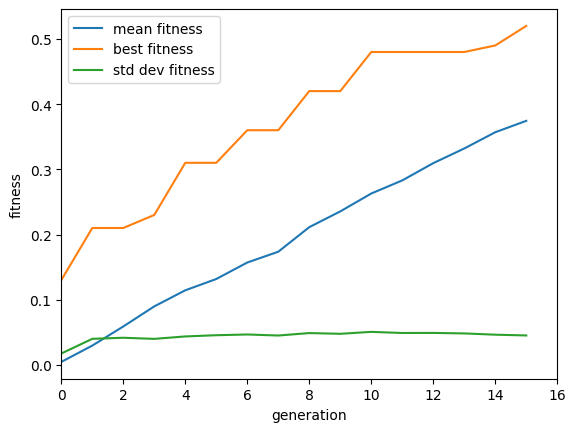

Alice (Evolved) won 34 times
Bob (NimSum) won 66 times


In [36]:
heaps = Nim(N_HEAPS)
solutions = evolve_nim_strategy(heaps)

# test on a match against a nim-sum strategy
solution = random.choice(solutions)
Alice = EvolutionalPlayer("Alice (Evolved)", solution, evolved_strategy)
Bob = Player("Bob (NimSum)", nim_sum_strategy)
winners = match(Alice, Bob, heaps, N_GAMES)
print_match_result(Alice, Bob, winners)

## Task3.3 MinMax

In [37]:
class GameNode:
    def __init__(self, state: list, parent: Union[object, None] = None, children: Union[list, None] = None):
        self._state = state
        self._parent = parent
        if children:
            self._children = children
        else:
            self._children = []
        self._value = 0

    def __hash__(self):
        return hash(bytes(self._state))

    @property
    def value(self):
        return self._value

    @value.setter
    def value(self, val):
        self._value = val

    @property
    def parent(self):
        return self._parent

    @parent.setter
    def parent(self, val):
        self._parent = val

    @property
    def children(self):
        return self._children

    def add_child(self, child):
        self._children.append(child)

    @property
    def state(self):
        return self._state


def heuristic(node: GameNode, hash_table: dict):
    # check if the value of the state has been already computed
    h = hash_table.get(node)
    if h is None:
        code = check_critical_situations(node.state) 
        if code > 0:
            h = float('inf')
        elif code < 0:
            h = -float('inf')
        else:
            if nim_sum(node.state) == 0: # bad state, gotta do a random action
                h = -1
            else:
                h = 1   # can reduce the nim-sum to zero
        hash_table[node] = h  # insert in hash_table for later use
    return h


def minmax(node: GameNode, depth: int, maximising: bool, hash_table: dict):
    if depth == 0:
        if sum(node.state) == 0: # if the node is a terminal state like [0, 0, 0]
            if maximising:
                node.value = float('inf') # i won because the opponent had like [0, 1, 0] and took the last object
            else:
                node.value = -float('inf') # i lost
        else:
            node.value = heuristic(node, hash_table)
        return node.value
    if maximising:
        node.value = -float('inf')
        for c in node.children:
            node.value = max(node.value, minmax(c, depth-1, False, hash_table))
        return node.value
    else:
        node.value = float('inf')
        for c in node.children:
            node.value = min(node.value, minmax(c, depth-1, True, hash_table))
        return node.value


def game_tree(state: list, parent: Union[GameNode, None], depth: int) -> GameNode:
    this_node = GameNode(state, parent, list())
    if depth > 0:
        for i in range(len(state)):
            # list all the possible new sizes of the heap state[i]
            for j in range(state[i]):
                child_state = copy.deepcopy(state)
                child_state[i] = j
                this_node.add_child(game_tree(child_state, this_node, depth-1))
    return this_node

class MinMaxPlayer(Player):
    def __init__(self, name, strategy, look_ahead):
        super().__init__(name, strategy)
        self._hash_table = {}
        self._look_ahead = look_ahead

    def flush_parameters(self):
        self._hash_table = {}
        super().flush_parameters()

    @property
    def hash_table(self):
        return self._hash_table
    
    @property
    def look_ahead(self):
        return self._look_ahead

def minmax_strategy(player: MinMaxPlayer, heaps: Nim):
    depth = player.look_ahead*2  # depth of the tree is the double of plies look ahead

    # generate game tree, access it through the root
    root = game_tree(heaps.rows, None, depth)

    # apply minmax algorithm, return the heuristic value of the action to be taken
    chosen_value = minmax(root, depth, True, player.hash_table)

    # select actions
    viable_children_idxs = [i for i, c in enumerate(root.children) if c.value == chosen_value]
    chosen_child_idx = random.choice(viable_children_idxs)
    chosen_child = root.children[chosen_child_idx]

    # compute the heap idx and the number of object to take
    difference = [i-j for i, j in zip(root.state, chosen_child.state)]
    num_objects = max(difference)
    chosen_heap = difference.index(num_objects)

    # nim the heap
    heaps.nimming(chosen_heap, num_objects, player)


In [43]:
# minmax vs random
heaps = Nim(N_HEAPS)
Alice = MinMaxPlayer("Alice (MinMax)", minmax_strategy, 1)
Bob = Player("Bob (Random)", random_strategy)
winners = match(Alice, Bob, heaps, N_GAMES)
print_match_result(Alice, Bob, winners)

Alice (MinMax) won 92 times
Bob (Random) won 8 times


In [41]:
# minmax vs minmax
heaps = Nim(N_HEAPS)
Alice = MinMaxPlayer("Alice (MinMax)", minmax_strategy, 1)
Bob = MinMaxPlayer("Bob (MinMax)", minmax_strategy, 1)
winners = match(Alice, Bob, heaps, N_GAMES)
print_match_result(Alice, Bob, winners)

Alice (MinMax) won 48 times
Bob (MinMax) won 52 times


In [42]:
# minmax vs nimsum
heaps = Nim(N_HEAPS)
Alice = MinMaxPlayer("Alice (MinMax)", minmax_strategy, 1)
Bob = Player("Bob (NimSum)", nim_sum_strategy)
winners = match(Alice, Bob, heaps, N_GAMES)
print_match_result(Alice, Bob, winners)

Alice (MinMax) won 32 times
Bob (NimSum) won 68 times


## Task3.4 Reinforcement Learning

In [5]:
LEARNING_RATE = 0.15
EXPLOITATION = 0.2
DECREASE_LR = 10e-5
LEARN_ITERATIONS = 5_000

In [13]:
class Agent(object):
    def __init__(self, initial_state: Nim, alpha: float = LEARNING_RATE, random_factor: float = EXPLOITATION):
        self.state_history = [([], int(0))]  # state, reward
        self.alpha = alpha
        self.random_factor = random_factor
        self.G = {}
        self.init_reward(initial_state)

    def init_reward(self, initial_state: Nim):
        for row in initial_state.rows:
            for n_obj in range(1, row + 1):
                self.G[(row, n_obj)] = np.random.uniform(low=1.0, high=0.1)

    def choose_action(self, state: Nim, allowedMoves: List[Tuple[int, int]]) -> Tuple[int, int]:
        maxG = -10e15
        next_move = (0,0)
        randomN = np.random.random()
        if randomN < self.random_factor:
            # if random number below random factor, choose random action
            next_move = np.random.choice(allowedMoves)
        else:
            # if exploiting, gather all possible actions and choose one with the highest G (reward)
            for action in allowedMoves:
                new_state = state.copy()
                new_state.nimming(action[0], action[1])
                if self.G[(action[0], action[1])] >= maxG:
                    next_move = action
                    maxG = self.G[(action[0], action[1])]

        return next_move

    def update_state_history(self, state: Nim, reward: int):
        self.state_history.append((state.rows, reward))

    def learn(self):
        target = 0

        for prev, reward in reversed(self.state_history):
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])
            target += reward

        self.state_history = []

        self.random_factor -= DECREASE_LR  # decrease random factor each episode of play

class ReinforcedPlayer(Player):
    def __init__(self, name: str, state: Nim, strategy: Callable, *strategy_args):
        super().__init__(name, strategy, strategy_args)
        self.state = state
        self.agent = Agent(state.copy())

    def flush_parameters(self):
        super().flush_parameters()

def play_RL(A: ReinforcedPlayer, B: Player, heaps: Nim) -> Player:
    while not (A.loser or B.loser):
        A.ply(heaps)
        if not A.loser:
            B.ply(heaps)
        state, reward = heaps.get_state_and_reward()
        A.agent.update_state_history(heaps, reward)
    if A.loser:
        return B
    return A

def match_RL(A: ReinforcedPlayer, B: Player, state: Nim, n_games: int = LEARN_ITERATIONS):
    winners = list()
    for i in range(n_games):
        initial_state = state.copy()
        A.flush_parameters()
        B.flush_parameters()
        r = random.random()
        w = play_RL(A, B, initial_state)
        winners.append((w.name, w.n_plies))
        A.agent.learn()
    return winners

def reinforced_strategy(player: ReinforcedPlayer, heaps: Nim, *strategy_args):
    state, _ = heaps.get_state_and_reward()
    actions = heaps.possible_actions()
    action = player.agent.choose_action(heaps, actions)
    heaps.nimming(action[0], action[1], player)

In [14]:
heaps = Nim(N_HEAPS)

Alice = ReinforcedPlayer('Alice (RL)', heaps, reinforced_strategy)
Bob = Player('Bob (Random)', random_strategy)
winners = match_RL(Alice, Bob, heaps)
print_match_result(Alice, Bob, winners)

KeyError: (1, 2)